In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [4]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [5]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()# - 1619483 - 1366115 - 813246
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#PEGAR SO AQUELES QUE TEM QUANTIDADE SENAO NAO ADIANTA FAZER VAR
    
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
# ver apenas aqueles que tem dados em pelo menos 50% ou mais dos quartis
#display(dfValidTypes[dfValidTypes['QtdNaoZero']>12])

dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C

In [6]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()
figsize=(12,8)
field = 'total'

In [7]:
dfMonth

,total,Apelação Cível,Agravo de Instrumento,Embargos de Declaração,Recurso Cível,Agravo,Apelação Crime,Habeas Corpus,Apelação e Reexame Necessário,Reexame Necessário,...,Medida Cautelar,Desaforamento,Crimes contra a honra,Incidente de Inconstitucionalidade,Impugnação à Assistência Judiciária,Impugnação ao Valor da Causa,Inquérito Policial,weekDay,weekType,Feriado
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-01-01,10,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,84,21,29
2000-02-01,222,151,35,2,0,4,1,0,25,1,...,0,0,0,0,0,0,0,85,21,29
2000-03-01,573,277,93,30,0,17,5,0,118,21,...,0,0,0,0,0,0,0,93,23,31
2000-04-01,647,343,145,19,0,18,3,2,89,14,...,0,0,0,0,0,0,0,95,20,29
2000-05-01,1096,595,318,78,0,11,7,3,53,16,...,1,0,0,0,0,1,0,87,23,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,41151,9180,7284,5763,4238,1977,2912,1440,843,295,...,1,2,0,0,0,0,0,90,23,31
2017-09-01,32798,6915,6131,3648,3040,1700,2465,1423,741,229,...,3,2,0,0,0,0,2,93,21,28
2017-10-01,37399,8114,6538,4982,4923,1382,2406,1103,679,366,...,1,0,0,2,0,0,3,91,22,30


,total,Apelação Cível,Agravo de Instrumento,Embargos de Declaração,Recurso Cível,Agravo,Apelação Crime,Habeas Corpus,Apelação e Reexame Necessário,Reexame Necessário,...,Medida Cautelar,Desaforamento,Crimes contra a honra,Incidente de Inconstitucionalidade,Impugnação à Assistência Judiciária,Impugnação ao Valor da Causa,Inquérito Policial,weekDay,weekType,Feriado
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,21.200000,inf,2.500000,inf,NaN,inf,inf,NaN,inf,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011905,0.000000,0.000000
2000-03-01,1.581081,0.834437,1.657143,14.0,NaN,3.25,4.0,NaN,3.72,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094118,0.095238,0.068966


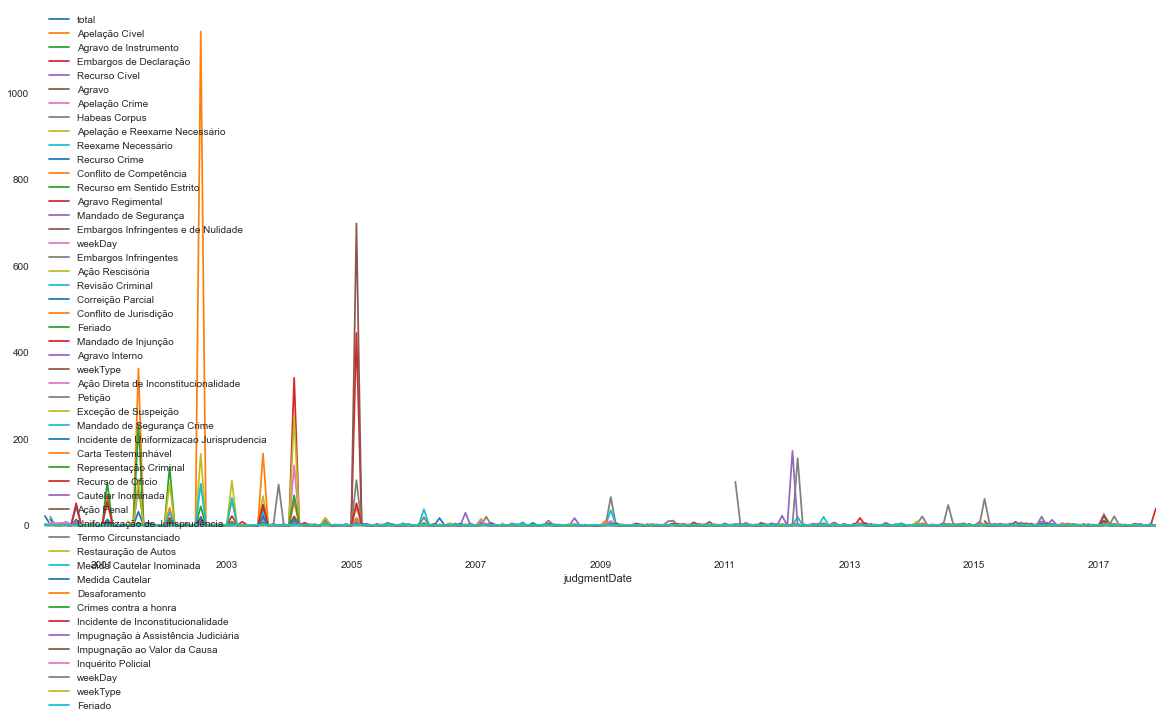

In [21]:
pctMonth = dfMonth.pct_change()
pctMonth.plot(figsize=(20,10))
display(pctMonth.head(3))

In [26]:
item1= 'total'
item2='Apelação Cível'
correlation= pctMonth[item1].corr(pctMonth[item2])
print(f'Correlation of {item1} and {item2}: {correlation}')

Correlation of total and Apelação Cível: nan


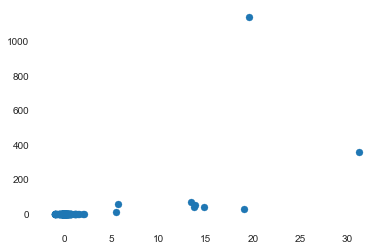

In [28]:
plt.scatter(pctMonth[item1],pctMonth[item2])

In [33]:
correlation1 = dfMonth[item1].corr(dfMonth[item2])
print("Correlation of levels: ", correlation1)

# Compute correlation of percent changes
changes = dfMonth.pct_change()
correlation2 = changes[item1].corr(changes[item2])
print("Correlation of changes: ", correlation2)

Correlation of levels:  0.9230118069325707
Correlation of changes:  nan


# Looking at a Regression's R-Squared

R-squared measures how closely the data fit the regression line, so the R-squared in a simple regression is related to the correlation between the two variables. In particular, the magnitude of the correlation is the square root of the R-squared and the sign of the correlation is the sign of the regression coefficient.

In this exercise, you will start using the statistical package statsmodels, which performs much of the statistical modeling and testing that is found in R and software packages like SAS and MATLAB.

You will take two series, x and y, compute their correlation, and then regress y on x using the function OLS(y,x) in the statsmodels.api library (note that the dependent, or right-hand side variable y is the first argument). Most linear regressions contain a constant term which is the intercept (the α in the regression yt=α+βxt+ϵt). To include a constant using the function OLS(), you need to add a column of 1's to the right hand side of the regression.

The module statsmodels.api has been imported for you as sm.

In [40]:
import statsmodels.api as sm

#print(dfMonth.columns)
x = dfMonth['total']
y = dfMonth['Apelação Cível']

# Compute correlation of x and y
correlation = x.corr(y)
print("The correlation between x and y is %4.2f" %(correlation))

# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['total'])

# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)
#print(dfx)
#print(dfx1)


# Regress y on dfx1
result = sm.OLS(y,dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

The correlation between x and y is 0.92
                            OLS Regression Results                            
Dep. Variable:         Apelação Cível   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1231.
Date:                Fri, 15 May 2020   Prob (F-statistic):           1.01e-90
Time:                        17:03:08   Log-Likelihood:                -1866.3
No. Observations:                 216   AIC:                             3737.
Df Residuals:                     214   BIC:                             3743.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [45]:
# Convert the daily data to weekly data
MSFT = dfMonth['total'].resample(rule='W')#, how='last')
print(MSFT)
# Compute the percentage change of prices
returns = MSFT.pct_change()

# Compute and print the autocorrelation of returns
autocorrelation = returns['total'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

DatetimeIndexResampler [freq=<Week: weekday=6>, axis=0, closed=right, label=right, convention=start, base=0]


AttributeError: 'DatetimeIndexResampler' object has no attribute 'pct_change'